In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# import torch.nn as nn
# from torch.nn import ReLU, Sigmoid
# from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
# import torch
# from torch.utils.tensorboard import SummaryWriter
from pycaret.regression import *

In [4]:
proteins = pd.read_csv('../data/train_proteins.csv')
peptides = pd.read_csv('../data/train_peptides.csv')
clinical_data = pd.read_csv('../data/train_clinical_data.csv')
clinical_data.set_index('visit_id', inplace=True)


In [5]:
npx_features = pd.pivot(proteins, index='visit_id',
                        values='NPX', columns='UniProt')


In [6]:
npx_features = npx_features.fillna(0)


<Axes: xlabel='UniProt', ylabel='UniProt'>

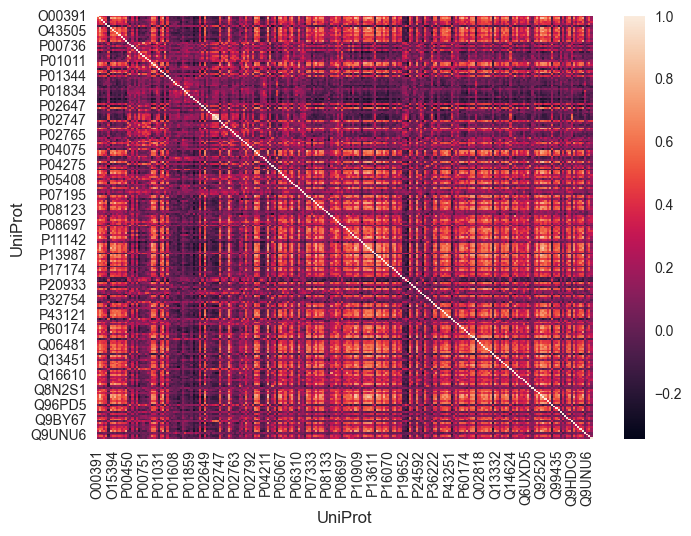

In [7]:
sns.heatmap(npx_features.corr())


In [8]:
clinical_data.head()


,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
visit_id,,,,,,,
55_0,55,0,10.0,6.0,6,NaN,NaN
55_3,55,3,10.0,7.0,19,NaN,NaN
55_6,55,6,8.0,10.0,58,NaN,NaN
55_9,55,9,8.0,9.0,17,0.0,On
55_12,55,12,10.0,10.0,2,0.0,On


In [9]:
li = []
for idx, v in enumerate(clinical_data.index.values):
    parts = v.split('_')
    if parts[1] == '0':
        li.append('00000')
    else:
        li.append(clinical_data.index.values[idx-1])

def offset_updrs2(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_2']

def offset_updrs1(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_1']

def offset_updrs3(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_3']

def offset_updrs4(row):
    if (row['offset'] == '00000'):
        return 0
    else:
        return clinical_data.loc[row['offset']]['updrs_4']

clinical_data['offset'] = li

clinical_data['offset_updrs2_offset'] = clinical_data.apply(
    offset_updrs2, axis=1)
clinical_data['offset_updrs1_offset'] = clinical_data.apply(
    offset_updrs1, axis=1)
clinical_data['offset_updrs3_offset'] = clinical_data.apply(
    offset_updrs3, axis=1)
clinical_data['offset_updrs4_offset'] = clinical_data.apply(
    offset_updrs4, axis=1)


def smape(a, b):
    return 100*pd.Series(abs((a-b)/((a+b)/2))).fillna(0).sum()/len(a)


clinical_data.fillna(0, inplace=True)


In [10]:
clinical_data = clinical_data[[
    'updrs_1', 'updrs_2', 'offset_updrs2_offset', 'offset_updrs1_offset','offset_updrs3_offset','offset_updrs4_offset', 'updrs_3', 'updrs_4']]


In [11]:
clinical_data

,updrs_1,updrs_2,offset_updrs2_offset,offset_updrs1_offset,offset_updrs3_offset,offset_updrs4_offset,updrs_3,updrs_4
visit_id,,,,,,,,
55_0,10.0,6.0,0.0,0.0,0,0.0,6,0.0
55_3,10.0,7.0,6.0,10.0,6,0.0,19,0.0
55_6,8.0,10.0,7.0,10.0,19,0.0,58,0.0
55_9,8.0,9.0,10.0,8.0,58,0.0,17,0.0
55_12,10.0,10.0,9.0,8.0,17,0.0,2,0.0
...,...,...,...,...,...,...,...,...
65043_48,7.0,6.0,10.0,9.0,4,0.0,51,0.0
65043_54,4.0,8.0,6.0,7.0,51,0.0,55,1.0
65043_60,6.0,6.0,8.0,4.0,55,1.0,0,1.0


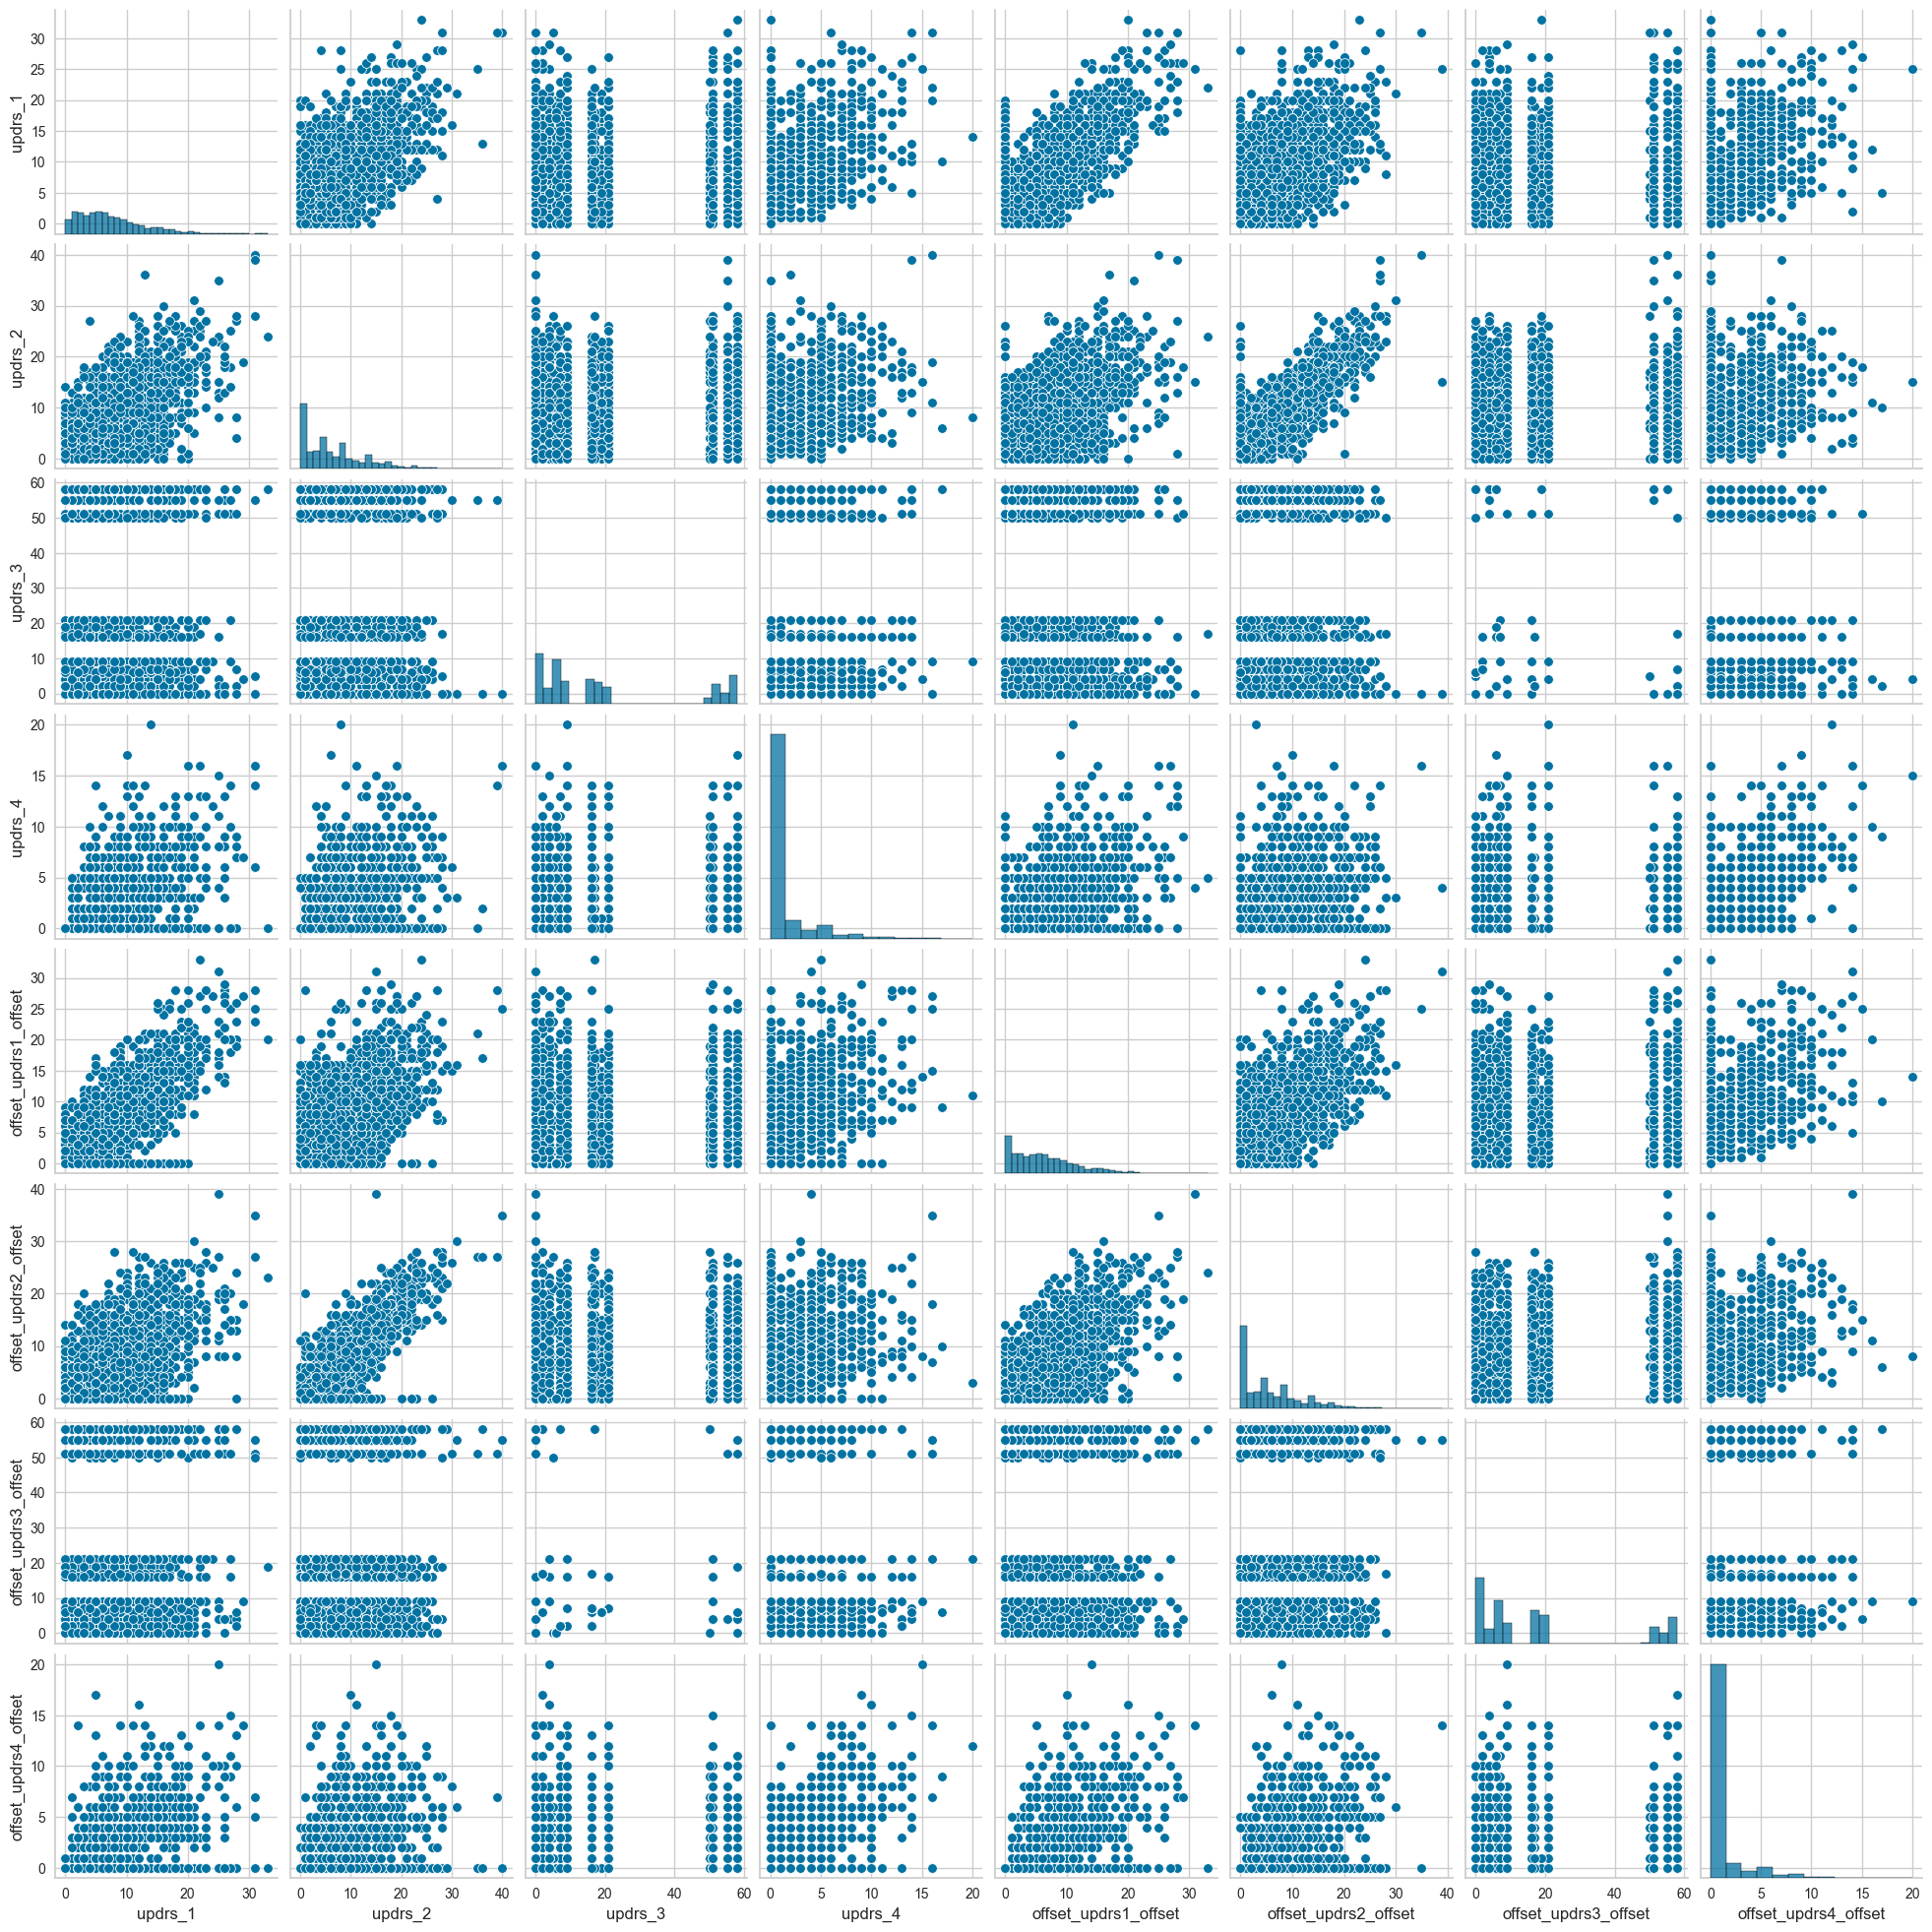

In [13]:
sns.pairplot(clinical_data[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4',
             'offset_updrs1_offset', 'offset_updrs2_offset', 'offset_updrs3_offset', 'offset_updrs4_offset']])


In [14]:
# p = peptides.pivot_table(values='PeptideAbundance',
#                          columns='Peptide', index=['visit_id', 'UniProt'])
# p.fillna(0, inplace=True)

In [27]:
# class ParkinsonDataSet(Dataset):
#     def __init__(self, clinical_data=clinical_data, npx_data=npx_features, peptide_data=p) -> None:
#         self.c = clinical_data
#         self.n = npx_data
#         self.p = p
#         self.ids = self.n.index.unique()
#         self.proteins= self.n.columns
#         self.peptides = self.p.columns

#     def __len__(self):
#         return 1113

#     def __getitem__(self, idx):
#         patient_id = self.ids[idx]
#         patient_peptides = self.p.loc[patient_id]
#         features = []
#         protein_peptides = []
#         # for protein in self.proteins:
#         #     peps = None
#         #     if (patient_id, protein) in self.p.index:
#         #         peps = patient_peptides.loc[protein].values
#         #     else:
#         #         peps = np.zeros(968)
#         #     protein_peptides.extend(peps)
#         # features.extend(protein_peptides)
#         try:
#             features.extend([self.c.loc[patient_id]['offset_updrs1_offset'],
#                             self.c.loc[patient_id]['offset_updrs2_offset']])
#             labels = [self.c.loc[patient_id]['updrs_1'], self.c.loc[patient_id]['updrs_2'],
#                     self.c.loc[patient_id]['updrs_2'], self.c.loc[patient_id]['updrs_3']]
#             return np.array(features), np.array(labels)
#         except:
#             return None


In [29]:
# pds = ParkinsonDataSet()
# #dataloader = DataLoader(pds, batch_size=1, num_workers=0)
# d = np.zeros(219738)
# l = np.zeros(4)
# for tup in tqdm(pds):
#     if tup:
#         d= np.vstack((d,tup[0]))
#         l=np.vstack((l,tup[1]))

 ... (more hidden) ...


KeyboardInterrupt: 

In [19]:
# d = d[1:]
# l = l[1:]

In [54]:
# len(d)

617

In [43]:
# unscaled_d = d.T[219736:].T
# scalable_d = d.T[:219736].T

# temp_df = pd.DataFrame(scalable_d)

# scalable_d = temp_df.replace(0, np.nan).dropna(axis=1,how='all').fillna(0).values

In [48]:
# pipe = Pipeline([
#     ('scale', StandardScaler())
# ])

# transform_d = pipe.fit_transform(scalable_d)

In [49]:
# final_d = np.hstack((transform_d,unscaled_d))

In [61]:
# l.T[1]

array([ 0.,  0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  3.,  6.,  6.,
        3.,  0.,  2.,  2.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  2.,  4.,
        4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
        2.,  2.,  3.,  3.,  2.,  5.,  3.,  1.,  1.,  1.,  0.,  1.,  3.,
       20., 27., 17.,  0.,  0.,  1.,  4., 15., 20.,  4.,  8.,  5.,  5.,
        0.,  0.,  0., 11.,  8.,  9.,  9.,  9.,  0.,  0.,  0.,  2.,  2.,
        0.,  6.,  3.,  3.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  9.,  5.,  8.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  4.,  4.,  8.,  5.,  2., 10.,  9.,  1.,
        1.,  2.,  3.,  3.,  6., 19.,  7.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  3., 10.,  2.,  8.,  0.,  0.,  0.,  2.,
       12., 12.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  2.,  8.,
       13.,  8.,  5.,  7.,  9., 16.,  0.,  1.,  1.,  2.,  3.,  2.,  4.,
        0.,  2.,  1.,  3.,  5.,  7.,  4.,  1.,  1.,  1.,  0.,  0

# UPDRS2 performance with all of the PCA features 

In [50]:
# s = setup(data=transform_d, target=l.T[1])

,Description,Value
0,Session id,1096
1,Target,target
2,Target type,Regression
3,Original data shape,"(617, 969)"
4,Transformed data shape,"(617, 969)"
5,Transformed train set shape,"(431, 969)"
6,Transformed test set shape,"(186, 969)"
7,Numeric features,968
8,Preprocess,True
9,Imputation type,simple


In [51]:
# best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.1254,19.2672,4.3054,0.0717,1.0168,0.7288,1.0930
br,Bayesian Ridge,3.1782,19.4032,4.3289,0.0543,1.0121,0.7790,0.2670
lightgbm,Light Gradient Boosting Machine,3.1661,19.3993,4.3189,0.0521,1.0096,0.8519,0.7570
rf,Random Forest Regressor,3.2716,19.9385,4.3874,0.0219,1.0547,0.7417,5.3230
knn,K Neighbors Regressor,3.0544,21.0140,4.4706,0.0104,0.9592,0.7819,0.2350
ada,AdaBoost Regressor,3.5275,20.6571,4.4767,-0.0197,1.1140,0.8431,0.7470
en,Elastic Net,3.4389,21.3236,4.5272,-0.0223,1.0747,0.7538,0.2340
gbr,Gradient Boosting Regressor,3.2488,20.8285,4.4795,-0.0345,1.0196,0.8256,3.1580
llar,Lasso Least Angle Regression,3.5223,21.8839,4.5842,-0.0461,1.0948,0.7648,0.2260
lasso,Lasso Regression,3.5223,21.8839,4.5842,-0.0461,1.0948,0.7648,0.2210


# UPDRS 1 Predictions with just protein data

In [15]:
dataset = pd.merge(clinical_data[['updrs_1', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()


,updrs_1,offset_updrs1_offset,offset_updrs2_offset,offset_updrs3_offset,offset_updrs4_offset,O00391,O00533,O00584,O14498,O14773,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,10.0,0.0,0.0,0,0.0,11254.3,732430.0,39585.8,41526.9,31238.00,...,365475.0,35528.0,97005.6,23122.5,60912.6,408698.0,0.0,29758.8,23833.7,18953.5
55_6,8.0,10.0,7.0,19,0.0,13163.6,630465.0,35220.8,41295.0,26219.90,...,405676.0,30332.6,109174.0,23499.8,51655.8,369870.0,0.0,22935.2,17722.5,16642.7
55_12,10.0,8.0,9.0,17,0.0,15257.6,815083.0,41650.9,39763.3,30703.60,...,303953.0,43026.2,114921.0,21860.1,61598.2,318553.0,65762.6,29193.4,28536.1,19290.9
55_36,17.0,14.0,13.0,21,0.0,13530.8,753832.0,43048.9,43503.6,33577.60,...,303597.0,48188.4,109794.0,23930.6,70223.5,377550.0,74976.1,31732.6,22186.5,21717.1
942_6,8.0,7.0,2.0,19,0.0,11218.7,399518.0,20581.0,31290.9,6173.58,...,253373.0,27431.8,93796.7,17450.9,21299.1,306621.0,82335.5,24018.7,18939.5,15251.2


In [16]:
Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[5:]].values
X_noscale = dataset[dataset.columns[1:5]].values


In [18]:
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))
len(final_X)

1068

In [19]:
s = setup(data=final_X, target=Y)

,Description,Value
0,Session id,1279
1,Target,target
2,Target type,Regression
3,Original data shape,"(1068, 232)"
4,Transformed data shape,"(1068, 232)"
5,Transformed train set shape,"(747, 232)"
6,Transformed test set shape,"(321, 232)"
7,Numeric features,231
8,Preprocess,True
9,Imputation type,simple


In [20]:
best = compare_models(sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.5804,12.0508,3.4538,0.5584,0.5936,0.6714,0.5460
et,Extra Trees Regressor,2.6554,12.5265,3.5196,0.5443,0.5998,0.7165,0.5730
rf,Random Forest Regressor,2.6663,12.6857,3.5463,0.5387,0.6016,0.7073,2.0550
gbr,Gradient Boosting Regressor,2.6435,12.8377,3.5602,0.5341,0.5952,0.6800,1.3690
en,Elastic Net,2.7172,13.4500,3.6455,0.5074,0.6226,0.7031,0.2300
lasso,Lasso Regression,2.7250,13.4738,3.6480,0.5070,0.6237,0.7085,0.2780
llar,Lasso Least Angle Regression,2.7250,13.4738,3.6480,0.5070,0.6237,0.7085,0.2210
br,Bayesian Ridge,2.7102,13.5247,3.6587,0.5020,0.6200,0.6931,0.2230
ada,AdaBoost Regressor,2.9607,14.0384,3.7281,0.4869,0.6832,0.9455,0.4180
omp,Orthogonal Matching Pursuit,2.8229,14.3137,3.7671,0.4715,0.6455,0.7132,0.2270


# UPDRS 2 Predictions with just Protein Data

In [21]:
dataset = pd.merge(clinical_data[['updrs_2', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()

Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[5:]].values
X_noscale = dataset[dataset.columns[1:5]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))
s = setup(data=final_X, target=Y)
best = compare_models(sort='R2')


,Description,Value
0,Session id,6108
1,Target,target
2,Target type,Regression
3,Original data shape,"(1068, 232)"
4,Transformed data shape,"(1068, 232)"
5,Transformed train set shape,"(747, 232)"
6,Transformed test set shape,"(321, 232)"
7,Numeric features,231
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,2.3719,10.5025,3.2226,0.6976,0.6575,0.5369,0.5750
rf,Random Forest Regressor,2.4560,11.2549,3.3430,0.6752,0.6942,0.5510,2.0740
en,Elastic Net,2.4780,11.4677,3.3546,0.6743,0.6995,0.5210,0.2360
lasso,Lasso Regression,2.4807,11.4778,3.3559,0.6740,0.7011,0.5209,0.3310
llar,Lasso Least Angle Regression,2.4808,11.4778,3.3559,0.6740,0.7011,0.5209,0.2350
br,Bayesian Ridge,2.4710,11.3994,3.3558,0.6730,0.6829,0.5460,0.2370
gbr,Gradient Boosting Regressor,2.4081,11.3829,3.3596,0.6723,0.6687,0.5340,1.3530
lightgbm,Light Gradient Boosting Machine,2.5004,12.0793,3.4569,0.6512,0.6878,0.5774,0.5440
omp,Orthogonal Matching Pursuit,2.5989,12.4281,3.5063,0.6423,0.7123,0.5814,0.2380
knn,K Neighbors Regressor,2.7248,14.0664,3.7188,0.5998,0.7067,0.5788,0.2390


# UPDRS 3 Predictions with Proteins Data

In [22]:
dataset = pd.merge(clinical_data[['updrs_3', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()

Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[5:]].values
X_noscale = dataset[dataset.columns[1:5]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))
s = setup(data=final_X, target=Y)
best = compare_models(sort='R2')


,Description,Value
0,Session id,956
1,Target,target
2,Target type,Regression
3,Original data shape,"(1068, 232)"
4,Transformed data shape,"(1068, 232)"
5,Transformed train set shape,"(747, 232)"
6,Transformed test set shape,"(321, 232)"
7,Numeric features,231
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,4.4194,70.7931,8.1815,0.8272,0.6880,0.5721,1.3380
lightgbm,Light Gradient Boosting Machine,4.9026,74.6504,8.4569,0.8180,0.7355,0.6470,0.5510
rf,Random Forest Regressor,4.3101,78.3192,8.5844,0.8089,0.6445,0.5077,1.3980
et,Extra Trees Regressor,6.3082,86.5476,9.1759,0.7887,0.7346,0.8607,0.4460
dt,Decision Tree Regressor,3.6665,152.0881,11.8839,0.6306,0.7272,0.4426,0.2640
ada,AdaBoost Regressor,14.7356,271.3748,16.4313,0.3144,1.2860,2.3980,0.4140
lasso,Lasso Regression,15.3304,364.3004,18.9770,0.1034,1.1497,2.0003,0.3320
llar,Lasso Least Angle Regression,15.3304,364.3002,18.9770,0.1034,1.1497,2.0003,0.3160
br,Bayesian Ridge,15.4214,366.4594,19.0329,0.0983,1.1658,2.0041,0.2530
en,Elastic Net,15.3931,367.9200,19.0760,0.0942,1.1652,2.0191,0.2720


# UPDRS 4 Predictions with Proteins Data

In [23]:
dataset = pd.merge(clinical_data[['updrs_4', 'offset_updrs1_offset', 'offset_updrs2_offset','offset_updrs3_offset','offset_updrs4_offset']],
                   npx_features, how='inner', left_on=['visit_id'], right_on=['visit_id'])
dataset.head()

Y = dataset[dataset.columns[0]].values
X = dataset[dataset.columns[5:]].values
X_noscale = dataset[dataset.columns[1:5]].values
X_scaled = StandardScaler().fit_transform(X)
final_X = np.hstack((X_noscale, X_scaled))
s = setup(data=final_X, target=Y)
best = compare_models(sort='R2')


,Description,Value
0,Session id,7452
1,Target,target
2,Target type,Regression
3,Original data shape,"(1068, 232)"
4,Transformed data shape,"(1068, 232)"
5,Transformed train set shape,"(747, 232)"
6,Transformed test set shape,"(321, 232)"
7,Numeric features,231
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
en,Elastic Net,1.0172,3.2175,1.7608,0.3582,0.5715,0.6078,0.2670
lasso,Lasso Regression,1.0626,3.3153,1.7854,0.3495,0.5810,0.5998,0.3030
llar,Lasso Least Angle Regression,1.0626,3.3153,1.7854,0.3495,0.5810,0.5998,0.2660
huber,Huber Regressor,0.8946,3.3742,1.8114,0.3156,0.5290,0.7162,0.3390
br,Bayesian Ridge,1.0916,3.2991,1.7940,0.3130,0.6030,0.6498,0.2660
et,Extra Trees Regressor,0.9629,3.2567,1.7882,0.3124,0.5686,0.6726,0.5190
lightgbm,Light Gradient Boosting Machine,1.0642,3.4034,1.8225,0.2969,0.5937,0.6920,0.6790
rf,Random Forest Regressor,0.9705,3.5081,1.8609,0.2706,0.5894,0.6956,3.2530
omp,Orthogonal Matching Pursuit,1.1851,3.5231,1.8639,0.2445,0.6418,0.7058,0.2660
gbr,Gradient Boosting Regressor,1.0102,3.6509,1.8956,0.2438,0.5901,0.6916,1.4430
